In [213]:
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *

In [215]:
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

## Zipline AlphaFactor Test

Run using jupyter notebook extension

In [3]:
%load_ext zipline

In [ ]:
%%zipline --start 2015-1-1 --end 2018-1-1 --output zipline.pickle

from zipline.api import (
    attach_pipeline,
    date_rules,
    time_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    get_open_orders,
    calendars
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
import numpy as np
import pandas as pd

MONTH = 21
YEAR = 12 * MONTH
N_LONGS = N_SHORTS = 25
VOL_SCREEN = 1000


class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())


def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs': mean_reversion.bottom(N_LONGS),
                             'shorts': mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))


def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = context.portfolio.positions.keys() - longs.union(shorts)

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)


def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)
    context.set_commission(commission.PerShare(cost=.01, min_trade_cost=0))
    context.set_slippage(slippage.VolumeShareSlippage())


def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')

## AlphaLens

In [227]:
performance = pd.read_pickle('zipline.pickle')

In [228]:
prices = pd.concat([df.to_frame(d) for d, df in performance.prices.items()],axis=1).T
prices.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in prices.columns]
prices.index = prices.index.normalize()
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 to 2017-12-29
Columns: 1760 entries, A to ZTS
dtypes: float64(1760)
memory usage: 13.5 MB


In [229]:
factor_data = pd.concat([df.to_frame(d) for d, df in performance.factor_data.items()],axis=1).T
factor_data.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data = factor_data.stack()
factor_data.index.names = ['date', 'asset']
factor_data.head()

date                       asset
2014-01-02 00:00:00+00:00  A         449.0
                           AAL      3073.0
                           AAP       768.0
                           AAPL     1491.0
                           ABBV      446.0
dtype: float64

In [230]:
with pd.HDFStore('../00_data/assets.h5') as store:
    sp500 = store['sp500/prices'].close
sp500 = sp500.resample('D').ffill().tz_localize('utc').filter(pricing.index.get_level_values(0))
sp500.head()

date
2012-01-03 00:00:00+00:00    1277.06
2012-01-04 00:00:00+00:00    1277.30
2012-01-05 00:00:00+00:00    1281.06
2012-01-06 00:00:00+00:00    1277.81
2012-01-09 00:00:00+00:00    1280.70
Name: close, dtype: float64

In [235]:
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=(1, 5, 10, 30),
                                                      quantiles=5)

Dropped 10.6% entries from factor data: 10.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


### Summary Tear Sheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1157.0,304.518132,190.754976,180238,20.043816
2,337.0,1892.0,863.460333,246.457779,179672,19.980872
3,774.0,2436.0,1434.529746,281.191549,179620,19.975090
4,1252.0,2802.0,2016.949925,278.691481,179672,19.980872
5,1800.0,3127.0,2582.517015,256.130220,180018,20.019350


Returns Analysis


,1D,5D,10D,30D
Ann. alpha,0.021,0.018,0.014,-0.010
beta,0.105,0.101,0.097,0.062
Mean Period Wise Return Top Quantile (bps),0.652,0.345,0.147,-0.742
Mean Period Wise Return Bottom Quantile (bps),-2.275,-2.198,-1.613,-0.165
Mean Period Wise Spread (bps),2.922,2.508,1.734,-0.591


Information Analysis


,1D,5D,10D,30D
IC Mean,0.017,0.016,0.017,0.004
IC Std.,0.141,0.141,0.129,0.117
Risk-Adjusted IC,0.124,0.111,0.131,0.032
t-stat(IC),NaN,NaN,4.107,0.993
p-value(IC),NaN,NaN,0.000,0.321
IC Skew,NaN,NaN,0.222,0.057
IC Kurtosis,NaN,NaN,-0.342,-0.396


Turnover Analysis


,10D,1D,30D,5D
Quantile 1 Mean Turnover,0.586,0.084,0.828,0.409
Quantile 2 Mean Turnover,0.736,0.134,0.807,0.642
Quantile 3 Mean Turnover,0.764,0.142,0.805,0.679
Quantile 4 Mean Turnover,0.739,0.133,0.805,0.638
Quantile 5 Mean Turnover,0.563,0.081,0.805,0.390


,1D,5D,10D,30D
Mean Factor Rank Autocorrelation,0.943,0.715,0.458,-0.009


<Figure size 432x288 with 0 Axes>

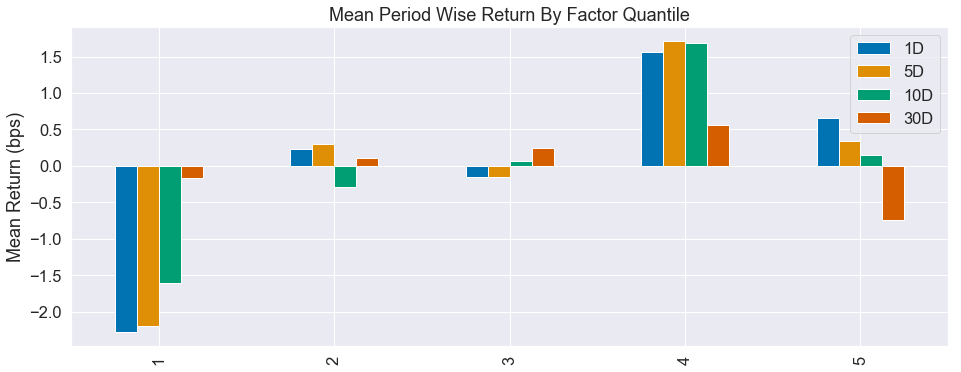

In [236]:
create_summary_tear_sheet(alphalens_data)

### Returns Analysis

In [237]:
mean_return_by_q, std_err = mean_return_by_quantile(alphalens_data)
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

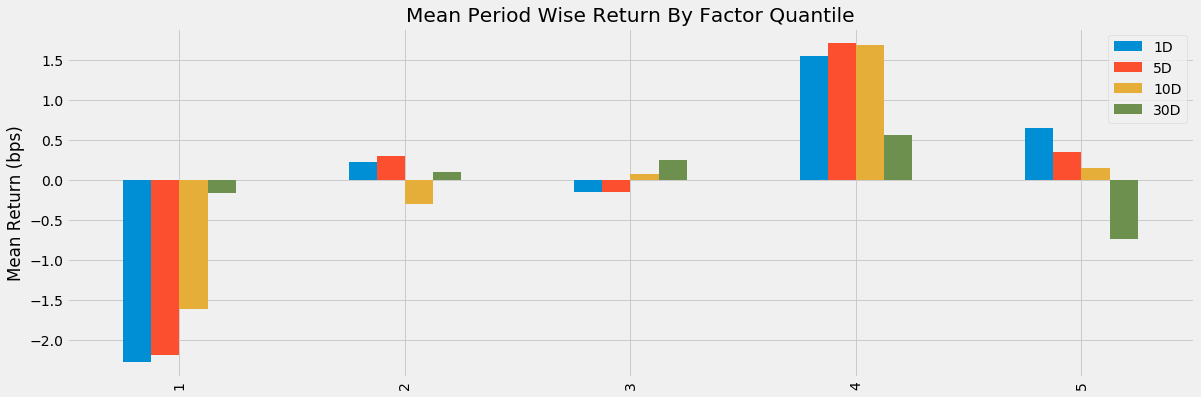

In [238]:
plot_quantile_returns_bar(mean_return_by_q_norm);

In [239]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(alphalens_data, by_date=True)

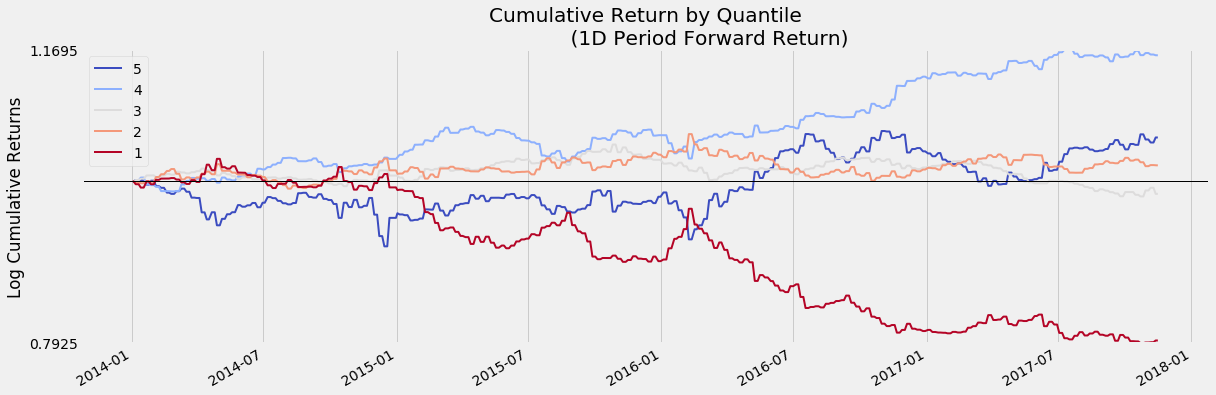

In [240]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['1D'], period='1D');